In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import warnings
#import astropy.units as U
#import astropy.constants as C
#from scipy.spatial.transform import Rotation as R


G     = 4.3e-6 # Grav. constant [kPc/M_{sun} (km/s)^2]
H0    = 67.74 # Hubble Constant [km/s / Mpc]
h     = H0 / 100 
rho_c = 3*(H0**2)/(8*np.pi*G*1e-3) # Critical density [M_{sun}/Mpc**3]
rho_c = rho_c * (1e-3 ** 3) #2.7754 * 1e2 * (H0/100)**2 # Critical density [M_{sun}/Kpc**3]
Nfields = 9
M_dm    = 7.5e6 # M_sun

In [2]:
#import illustris_python as il
import pts.simulation as sm
import pts.utils as ut
import pts.visual as vis
import pts.band as bd
import pts.do

In [3]:
!ls ../data/particles/

halo_31_gasCoord.txt	       subhalo_165727_starsHsml.txt
halo_31_gasHsml.txt	       subhalo_165727_starsInitMass.txt
halo_31_gasMasses.txt	       subhalo_165727_starsMasses.txt
halo_31_gasMetal.txt	       subhalo_165727_starsMetal.txt
halo_31_gasVels.txt	       subhalo_165727_starsSFT.txt
halo_31_starsCoord.txt	       subhalo_165727_starsVels.txt
halo_31_starsHsml.txt	       subhalo_165728_gasCoord.txt
halo_31_starsInitMass.txt      subhalo_165728_gasDens.txt
halo_31_starsMasses.txt        subhalo_165728_gasHsml.txt
halo_31_starsMetal.txt	       subhalo_165728_gasMasses.txt
halo_31_starsSFT.txt	       subhalo_165728_gasMetal.txt
halo_31_starsVels.txt	       subhalo_165728_gasVels.txt
subhalo_165727_gasCoord.txt    subhalo_165728_starsCoord.txt
subhalo_165727_gasDens.txt     subhalo_165728_starsHsml.txt
subhalo_165727_gasHsml.txt     subhalo_165728_starsInitMass.txt
subhalo_165727_gasMasses.txt   subhalo_165728_starsMasses.txt
subhalo_165727_gasMetal.txt    subhalo_165728_starsMetal.txt

In [4]:
subID = 165727
try:
    folder = '../data/TNGgalaxies/' + str(subID)
    os.mkdir(folder)
except:
    pass

In [5]:
particles = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsHsml.txt') / h # Hsml [kPc]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsInitMass.txt') * (1e10) / h # [Msun]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

stars_SFT = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_starsSFT.txt')

stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6

particles = np.hstack((particles, stars_t0.reshape(npart, 1)))

/tmp/ipykernel_1723165/2606003752.py:18: RuntimeWarning: invalid value encountered in power
  stars_t0 = 13.8 * (1. - stars_SFT**1.5) + 1e-6


In [6]:
particles.shape

(683121, 10)

In [7]:
# Discard wind particles (definition from illustris documentation: 
#      https://www.tng-project.org/data/docs/specifications/#parttype0

ind_wind = np.where(stars_SFT <= 0)[0]
if len(ind_wind) > 0:
    particles = np.delete(particles, ind_wind, axis=0)

# Transform data to be center on the Center of Mass of the cluster, and rotate to be edge-on
#.
#.
#.
#.

# Discard particles outside certain radii
#.
#.
#.
#.

# Separare old from young stars:

# from where do we get this formula???

# from where do we get this condition???

ind_old = np.where(particles[:,9] > 1e-2)[0]
ind_new = np.where(particles[:,9] <= 1e-2)[0]

particles_old = particles[ind_old]
particles = particles[ind_new]

if len(ind_old) > 0:
    stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    #stars_old_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) +  \
    #                   ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family' + \
    #                   '\n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc)' + \
    #                   '\n Column 4: particle smoothing length (kpc)' +  \
    #                   '\n Column 8: initial mass (Msun) \n Column 9: metallicity (1) \n Column 10: age (Gyr) \n'
    np.savetxt(folder + '/stars_old_v.txt', particles_old, header = stars_old_header)
    
if len(ind_new) > 0:
    log10C = np.repeat(5, len(ind_new)).reshape(len(ind_new),1)
    P = np.repeat(0.1, len(ind_new)).reshape(len(ind_new),1)
    ccf = np.repeat(0.2, len(ind_new)).reshape(len(ind_new),1)
    particles[:,7] = particles[:,7] / particles[:,9] * 1e9 # I dont know why we do this
    
    particles = np.hstack((particles, log10C, P, ccf))
    stars_sb_header = ' Stellar particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a particle source with the Bruzual Charlot SED family \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: particle smoothing length (kpc) \n Column 5: x-velocity (km/s) \n Column 6: y-velocity (km/s) \n Column 7: z-velocity (km/s) \n Column 8: star formation rate (Msun/yr) \n Column 9: metallicity (1) \n Column 10: compactness (1) \n Column 11: pressure (K/m3) \n Column 12: cloud covering fraction (1) \n'

    np.savetxt(folder + '/stars_sb_v.txt', particles, header = stars_sb_header)

In [8]:
particles = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasCoord.txt') / h # [kPc]
npart = len(particles)

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasDens.txt') * (1e10) * (h**2) # [Msun / kPc^3]
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasMetal.txt')
particles = np.hstack((particles, aux.reshape(npart, 1)))

aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasVels.txt') # Vels [km sqrt(a)/s]
particles = np.hstack((particles, aux))

#stars_SFT = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasSFT.txt')

#aux = np.loadtxt('../data/particles/subhalo_' + str(subID) + '_gasHsml.txt') / h # Hsml [kPc]
#particles = np.hstack((particles, aux.reshape(npart, 1)))

# Let's save the data
particles[:,3] = particles[:,3] * 1e-9 # Convert to [M_sun / Pc^3]
gas_header = ' Gas particles for IllustrisTNG 100-1 subhaloID=' + str(subID) + ' \n SKIRT 9 import format for a medium source using M_dust = f_dust x Z x M_gas \n Column 1: x-coordinate (kpc) \n Column 2: y-coordinate (kpc) \n Column 3: z-coordinate (kpc) \n Column 4: gas mass volume density (Msun/pc3) \n Column 5: metallicity (1) \n Column 6: x-velocity (km/s) \n Column 7: y-velocity (km/s) \n Column 8: z-velocity (km/s) \n '
np.savetxt(folder + '/gas_v.txt', particles, header = gas_header)
  

In [9]:
n_px = 50
D = 5
px_s = 16.11
Rmax = int(0.5 * n_px * D * 1e3 * px_s * 4.848e-6)
print("Rmax: ", Rmax)
#self.get_data(subID, snapID, rot, folder, Rmax)
Rframe = Rmax * 1e3
Rsource1 = 0.5 * Rframe
Rsource2 = 0.1 * Rframe
Rmedium = 0.5 * Rframe *1e6
Rgrid = 0.5 * Rframe
#print(Rmax)
#Rmax = 14.961969356639141
#Rmax = 0.5 * Rframe
#Rsource1 = Rmax
#Rsource2 = Rmax
#Rmedium = Rmax
#Rgrid = Rmax

skifile = sm.SkiFile('template.ski')
#skifile = sm.SkiFile('template_sb-sph.ski')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minX', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxX', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minY', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxY', str(Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'minZ', str(-Rsource1) + ' pc')
##skifile.setStringAttribute('.//VoronoiMeshSource', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minX', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxX', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minY', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxY', str(Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'minZ', str(-Rsource1) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[1]', 'maxZ', str(Rsource1) + ' pc')

#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minX', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxX', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minY', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxY', str(Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'minZ', str(-Rsource2) + ' pc')
#skifile.setStringAttribute('(.//VoronoiMeshSource)[2]', 'maxZ', str(Rsource2) + ' pc')

skifile.setStringAttribute('.//ParticleSource', 'filename', 'stars_old_v.txt')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'filename', 'gas_v.txt')

skifile.setStringAttribute('.//VoronoiMeshMedium', 'minX', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxX', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minY', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxY', str(Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'minZ', str(-Rmedium) + ' pc')
skifile.setStringAttribute('.//VoronoiMeshMedium', 'maxZ', str(Rmedium) + ' pc')

#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minX', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxX', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minY', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxY', str(Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'minZ', str(-Rgrid) + ' pc')
#skifile.setStringAttribute('.//VoronoiMeshSpatialGrid', 'maxZ', str(Rgrid) + ' pc')

skifile.setNumPrimaryPackets(2e7)
skifile.setStringAttribute('.//FrameInstrument', 'distance', str(D) + ' Mpc')
skifile.setStringAttribute('.//FrameInstrument', 'inclination', '90 deg')
skifile.setStringAttribute('.//FrameInstrument', 'azimuth', '180 deg')
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsX', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'numPixelsY', str(n_px))
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewX', str(Rframe) + ' pc')
skifile.setStringAttribute('.//FrameInstrument', 'fieldOfViewY', str(Rframe) + ' pc')

skifile.saveTo(folder + '/galaxy.ski')

Rmax:  9


In [16]:
skirt = sm.Skirt()
simulation = skirt.execute(folder + '/galaxy.ski', inDirPath=folder, outDirPath=folder, numThreadsPerProcess=4, console='brief') #brief

28/10/2024 15:15:20.693   Welcome to SKIRT v9.0 (git 8765014 built on 23/10/2024 at 17:15:30)
28/10/2024 15:15:20.693   Running on coglians.phys.sissa.it for mdelosri
28/10/2024 15:15:20.695   Constructing a simulation from ski file '/u/m/mdelosri/MaDaMe/data/TNGgalaxies/165727/galaxy.ski'...
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 1024
Order 3 vertex memory scaled up to 1024
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 1024
Order 3 vertex memory scaled up to 1024
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 1024
Order 3 vertex memory scaled up to 1024
Vertex memory scaled up to 512
Order 3 vertex memory scaled up to 512
Vertex memory scaled up to 1024
Order 3 vertex memory scaled up to 102

In [17]:
SDSS_U = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_U_BroadBand.stab')
SDSS_G = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_G_BroadBand.stab')
SDSS_R = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_R_BroadBand.stab')
SDSS_I = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_I_BroadBand.stab')
SDSS_Z = bd.BroadBand('/u/m/mdelosri/SKIRT/resources/SKIRT9_Resources_Core/Band/SLOAN_SDSS_Z_BroadBand.stab')


In [18]:
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_U', contributions=[[SDSS_U, 1., 0, 0], [SDSS_U, 0, 1., 0],[SDSS_U, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_G', contributions=[[SDSS_G, 1., 0, 0], [SDSS_G, 0, 1., 0],[SDSS_G, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_R', contributions=[[SDSS_R, 1., 0, 0], [SDSS_R, 0, 1., 0],[SDSS_R, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_I', contributions=[[SDSS_I, 1., 0, 0], [SDSS_I, 0, 1., 0],[SDSS_I, 0, 0, 1.]], fmin=1e-5, fmax=1e3)
vis.makergbimages.makeConvolvedRGBImages(simulation, name='SDSS_Z', contributions=[[SDSS_Z, 1., 0, 0], [SDSS_Z, 0, 1., 0],[SDSS_Z, 0, 0, 1.]], fmin=1e-5, fmax=1e3)


(<Quantity 1.e-05 MJy / sr>, <Quantity 1000. MJy / sr>)

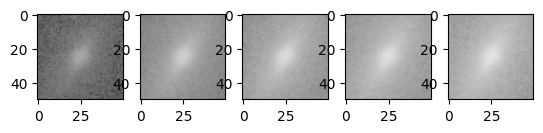

In [19]:
# Load the image
imgU = mpimg.imread(folder + "/galaxy_cube_total_SDSS_U.png")
imgG = mpimg.imread(folder + "/galaxy_cube_total_SDSS_G.png")
imgR = mpimg.imread(folder + "/galaxy_cube_total_SDSS_R.png")
imgI = mpimg.imread(folder + "/galaxy_cube_total_SDSS_I.png")
imgZ = mpimg.imread(folder + "/galaxy_cube_total_SDSS_Z.png")

# Display the image
fig,ax = plt.subplots(1,5)
ax[0].imshow(imgU)
ax[1].imshow(imgG)
ax[2].imshow(imgR)
ax[3].imshow(imgI)
ax[4].imshow(imgZ)
